# Proteomic profiles of resistance to Brown Ring disease in the Manila clam (Ruditapes philippinarum)

## Introduction
This notebook aims to identify all proteins that are differentially expressed between two groups of Manila clams (Resistant and Diseased) infected by Vibrio tapetis.
It suggest some improvements for appropriate statistical analyses regarding the distribution of the data (normality and homoscedasticity)

## Prepare working directory

In [1]:
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(dplyr))

In [2]:
dir.create("outputs", showWarnings = FALSE, recursive = TRUE)

## Import data

In [3]:
protein <- read.csv("input/proteins.csv") # Ce jeux de donnée contient les locus des protéines ainsi que l'abondance de la protéine dans chaque échantillon des deux groupes expérimentaux (phénotype résistant et phénotype malade)


## Identify proteins of interest (significant difference, and high fold change) with appropriate mean test 

In [19]:
for (i in 1:nrow(protein)) {
  # Récupérer les données pour les deux groupes et transformer en log2
  sick <- as.numeric(log2(protein[i, 11:13]))
  resistant <- as.numeric(log2(protein[i, 14:16]))
  
  # Remplacer les valeurs infinies (-Inf ou Inf) par NA (log2 de 0 donne -Inf)
  sick[is.infinite(sick)] <- NA
  resistant[is.infinite(resistant)] <- NA
  
  # Vérifier qu'il y a au moins 5 valeurs non-NA et non nulles
  if (sum(c(sick, resistant) > 0, na.rm = TRUE) >= 5) {
    # Récupérer les intensités totales des top trois peptides (non transformées en log2)
    sick_pept <- as.numeric(protein[i, 26])
    resist_pept <- as.numeric(protein[i, 27])
    
    # Calcul du Fold Change sur la base des top 3 peptides
    protein$Fold_Change[i] <- sick_pept / resist_pept
    protein$Log2_Fold_Change[i] <- log2(sick_pept / resist_pept) # log2 du fold change pour le volcano plot
    
    # Test de normalité avec Shapiro-Wilk (ne fonctionne que pour n >= 3)
    normal_sick <- if (length(na.omit(sick)) >= 3) shapiro.test(sick)$p.value > 0.05 else FALSE
    normal_resistant <- if (length(na.omit(resistant)) >= 3) shapiro.test(resistant)$p.value > 0.05 else FALSE
    
    # Test d'égalité des variances avec test de Levene 
    var_equal <- if (!any(is.na(c(sick, resistant)))) {
      var.test(sick, resistant)$p.value > 0.05
    } else {
      FALSE
    }
    
    # Adapter le test statistique en fonction des conditions
    if (normal_sick && normal_resistant && var_equal) {
      # Test t de Student
      t_test <- t.test(sick, resistant, var.equal = TRUE, na.action = na.omit)
    } else if (normal_sick && normal_resistant && !var_equal) {
      # Test t de Welch (variances inégales)
      t_test <- t.test(sick, resistant, var.equal = FALSE, na.action = na.omit)
    } else {
      # Test de Wilcoxon (non-paramétrique)
      t_test <- suppressWarnings(wilcox.test(sick, resistant, na.action = na.omit))
    }
    
    # Stocker les résultats
    protein$P_value[i] <- t_test$p.value
    protein$log10P_value[i] <- log10(t_test$p.value) # log10 p_value pour le volcano plot
    
  } else {
    # Si condition des 5 valeurs non remplie, assigner NA à toutes les colonnes calculées
    protein$Fold_Change[i] <- NA
    protein$Log2_Fold_Change[i] <- NA
    protein$P_value[i] <- NA
    protein$log10P_value[i] <- NA
  }
}

In [13]:
# Ajouter une colonne pour catégoriser les protéines (Significativité et importance du fold change)
fold_threshold <- 1.5

protein$Significant <- "Not Significant"
protein$Significant[protein$P_value<0.05] <- "Significant"

protein$Category <- "Not Significant"
protein$Category[protein$P_value < 0.05 & 
                        (protein$Fold_Change >= fold_threshold | 
                           protein$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein$Significant== "Significant") # = 102 Protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein$Category == "Significant and high fold change") # = 62 ont un fold change important, mais !! IL Y A DES DOUBLONS !!


In [14]:
### Nettoyer le jeux de données pour ne garder que les protéines uniques
protein_unique <- protein %>%
  distinct(Fold_Change, .keep_all = TRUE)

protein_unique$Significant <- "Not Significant"
protein_unique$Significant[protein_unique$P_value<0.05] <- "Significant"

protein_unique$Category <- "Not Significant"
protein_unique$Category[protein_unique$P_value < 0.05 & 
                   (protein_unique$Fold_Change >= fold_threshold | 
                      protein_unique$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important


In [15]:
# Charger les données et créer une nouvelle colonne `locus`
protein_unique <- protein_unique %>%
  mutate(locus = sub(".*\\|Locus_(.*?)\\.p[12].*", "\\1", Accession))

## Locus de toutes les 49 protéines significativement différentes et avec un important fold change
locus_high_fold_proteins <- protein_unique$locus[protein_unique$Category == "Significant and high fold change"]

## Toutes nos 49 protéines d'intérêt 
proteins_of_interest <- protein_unique %>%
  filter(Category == "Significant and high fold change")

## Export data

In [16]:
write.csv2(proteins_of_interest, "outputs/alt_proteins_of_interest.csv")

Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file 'outputs/alt_proteins_of_interest.csv': Permission denied”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


## Volcano plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


[1] 74

[1] 42

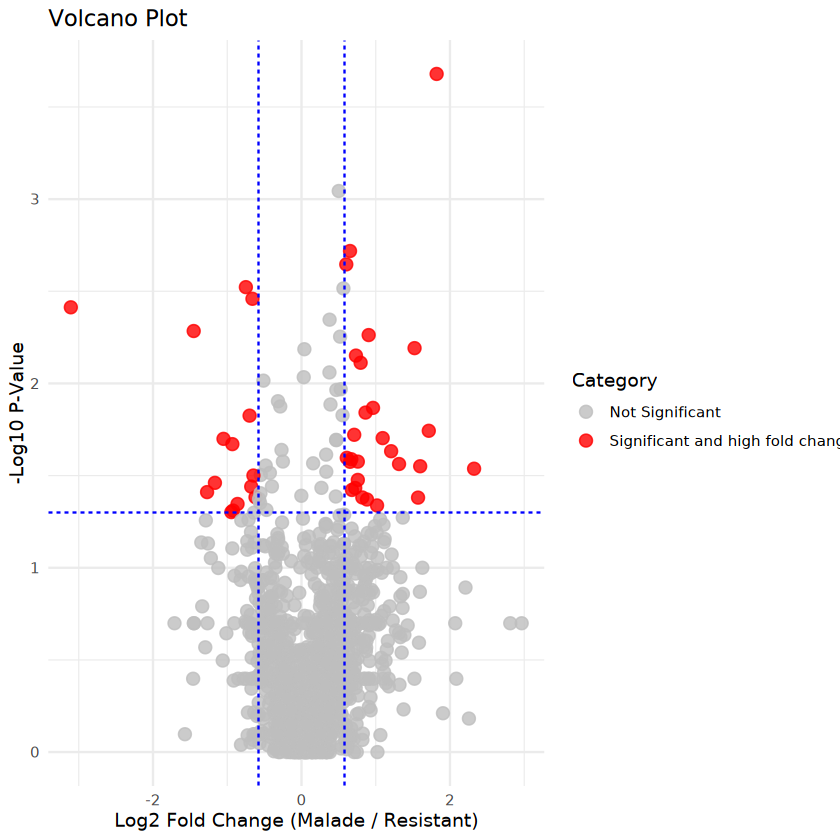

In [18]:
library(ggplot2)
volcano_plot <- ggplot(protein_unique, aes(x = Log2_Fold_Change, y = abs(log10P_value), color = Category)) +
  geom_point(alpha = 0.8, size = 3) +
  scale_color_manual(values = c("Not Significant" = "grey", "Significant and high fold change" = "red")) +
  geom_vline(xintercept = c(-log2(fold_threshold), log2(fold_threshold)), linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  theme_minimal() +
  labs(
    title = "Volcano Plot",
    x = "Log2 Fold Change (Malade / Resistant)",
    y = "-Log10 P-Value"
  )

# Afficher le plot
print(volcano_plot)
sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important

